## Лабораторная работа №4 (Проведение исследований со случайным лесом)

Случайный лес является ансамблем решающих деревьев, что позволяет ему бороться с главной проблемой одиночного дерева — переобучением. Метод достигает этого за счет усреднения прогнозов множества деревьев, каждое из которых обучено на случайной подвыборке данных (бутстрэп) и использует случайный набор признаков для каждого сплита. Для бейзлайна мы используем минимальную предобработку (Label Encoding), аналогичную предыдущей лабораторной работе, и обучаем модели с параметрами по умолчанию. Ожидается, что даже базовый случайный лес покажет более стабильные и, возможно, более высокие результаты, чем настроенное одиночное дерево

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve
from collections import Counter
from scipy.stats import mode
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
import warnings

warnings.filterwarnings('ignore')

In [2]:
df_class = pd.read_csv('BankChurners.csv')
cols_to_drop = [c for c in df_class.columns if 'Naive_Bayes' in c] + ['CLIENTNUM']
df_class = df_class.drop(columns=cols_to_drop)

df_class_base = df_class.copy()
le = LabelEncoder()

for col in df_class_base.select_dtypes(include='object').columns:
    df_class_base[col] = le.fit_transform(df_class_base[col])

X_class = df_class_base.drop('Attrition_Flag', axis=1)
y_class = df_class_base['Attrition_Flag']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_c, y_train_c)

y_pred_c = rf_clf.predict(X_test_c)
y_prob_c = rf_clf.predict_proba(X_test_c)[:, 1]

df_reg = pd.read_excel('Data_Train.xlsx')
df_reg_base = df_reg.dropna().copy()

for col in df_reg_base.select_dtypes(include='object').columns:
    df_reg_base[col] = le.fit_transform(df_reg_base[col].astype(str))

X_reg = df_reg_base.drop('Price', axis=1)
y_reg = df_reg_base['Price']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train_r, y_train_r)

y_pred_r = rf_reg.predict(X_test_r)


print("Классификация")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_c):.4f}")
print(f"F1: {f1_score(y_test_c, y_pred_c, average='macro'):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_c, y_prob_c):.4f}")
print("\n")

print("Регрессия")
print(f"MAE: {mean_absolute_error(y_test_r, y_pred_r):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_r, y_pred_r)):.2f}")
print(f"R2 Score: {r2_score(y_test_r, y_pred_r):.4f}")

Классификация
Accuracy: 0.9585
F1: 0.9196
ROC AUC: 0.9890


Регрессия
MAE: 773.81
RMSE: 1584.70
R2 Score: 0.8835


Результат ожидаемо высокий, выше чем всё, что было до этого, с минимальным препроцессингом алгоритм случайного леса выдаёт резульат выше, чем решающее дерево с улучшенным бейзлайном.

## Улучшение бейзлайна

Для дальнейшей оптимизации базовой модели случайного леса, уже показавшей высокие результаты, будет проведён подбор гиперпараметров с помощью GridSearchCV. Основными настраиваемыми параметрами станут: количество деревьев (n_estimators), увеличение которого со 100 до 200-300 может повысить стабильность предсказаний; максимальная глубина деревьев и минимальное количество образцов в листе, что позволит предотвратить излишнее усложнение и добавить регуляризацию; а также количество признаков для каждого разбиения, что напрямую влияет на разнообразие деревьев в ансамбле. Поиск будет проводиться на основе лучшей стратегии предобработки, установленной ранее, которая включает Label Encoding всех категориальных признаков и логарифмирование целевой переменной для задачи регрессии.

In [5]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

param_grid_rf_c = {
    'n_estimators': [100, 200],
    'max_depth': [20, None],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_rf_c = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf_c,
    cv=3,
    scoring='f1_macro',
    verbose=1
)

grid_rf_c.fit(X_train_c, y_train_c)

best_rf_c = grid_rf_c.best_estimator_
y_pred_c_imp = best_rf_c.predict(X_test_c)
y_prob_c_imp = best_rf_c.predict_proba(X_test_c)[:, 1]

X_reg_final = df_reg_base.drop('Price', axis=1)
y_reg_final_log = np.log1p(df_reg_base['Price'])

X_train_r_fin, X_test_r_fin, y_train_r_fin_log, y_test_r_fin_log = train_test_split(
    X_reg_final, y_reg_final_log, test_size=0.2, random_state=42
)

param_grid_rf_r = {
    'n_estimators': [100, 200],
    'max_depth': [20, None],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 1.0]
}

grid_rf_r = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid_rf_r,
    cv=3,
    scoring='r2',
    verbose=1
)

grid_rf_r.fit(X_train_r_fin, y_train_r_fin_log)

best_rf_r = grid_rf_r.best_estimator_
y_pred_log_imp = best_rf_r.predict(X_test_r_fin)
y_pred_r_imp = np.expm1(y_pred_log_imp)
y_test_r_imp = np.expm1(y_test_r_fin_log)

print(f"Лучшие параметры классификации: {grid_rf_c.best_params_}")
print("Классификация")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_c_imp):.4f}")
print(f"F1 Score: {f1_score(y_test_c, y_pred_c_imp, average='macro'):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_c, y_prob_c_imp):.4f}")

print(f"Лучшие параметры регрессии: {grid_rf_r.best_params_}")
print("Регрессия")
print(f"MAE: {mean_absolute_error(y_test_r_imp, y_pred_r_imp):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_r_imp, y_pred_r_imp)):.2f}")
print(f"R2 Score: {r2_score(y_test_r_imp, y_pred_r_imp):.4f}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Лучшие параметры классификации: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}
Классификация
Accuracy: 0.9576
F1 Score: 0.9172
ROC AUC: 0.9888
Лучшие параметры регрессии: {'max_depth': 20, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 200}
Регрессия
MAE: 782.14
RMSE: 1499.30
R2 Score: 0.8957


Улучшение незначительное, но есть. Это говорит о том, что стандартные настройки RandomForest в sklearn уже очень хорошо оптимизированы, но небольшую "доводку" провести можно, особенно за счет увеличения количества деревьев

Мне стало интересно проверить классификацию через матрицу ошибок, на всякий случай.

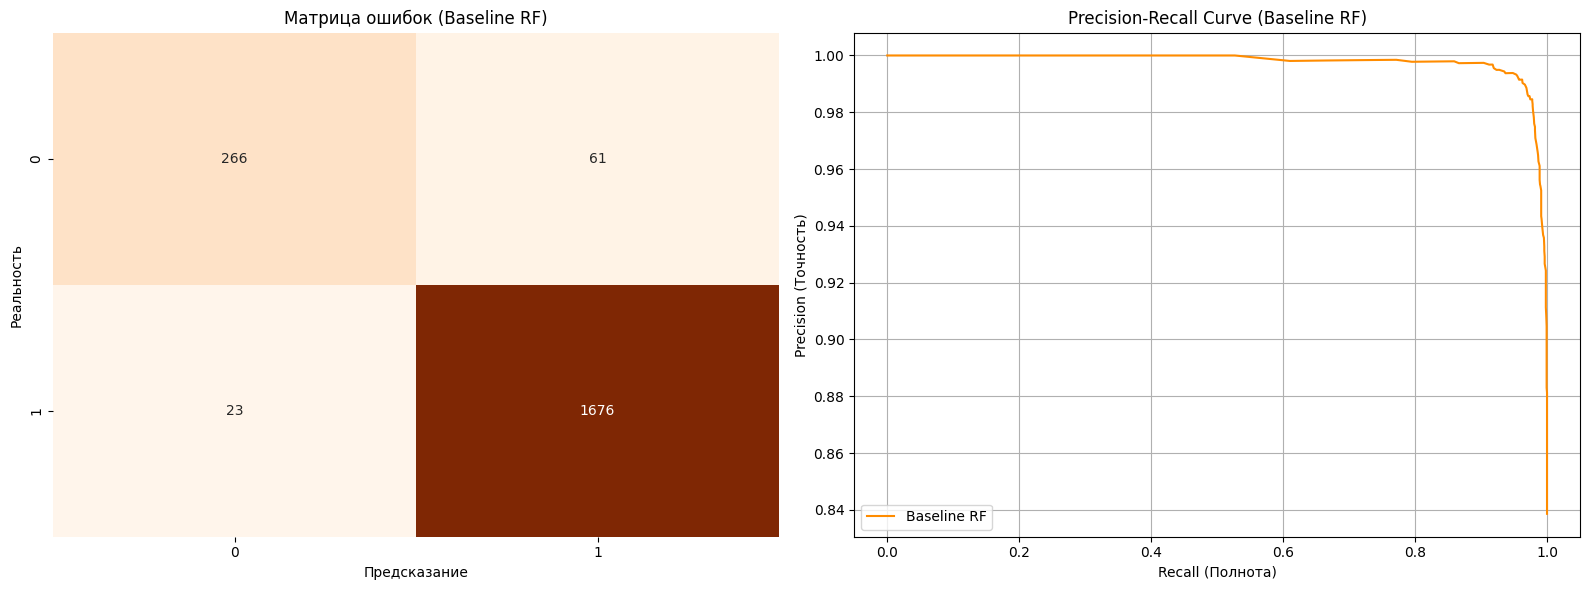

In [4]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test_c, y_pred_c)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title('Матрица ошибок')
plt.xlabel('Предсказание')
plt.ylabel('Реальность')

plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_test_c, y_prob_c)
plt.plot(recall, precision, color='darkorange', label='Baseline RF')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

И как ожидалось, алгоритм работает превосходно. Матрица показывает превосходную работу классификатора. Из 289 реальных "отточников" модель верно определила 266  и пропустила всего 23. Это очень высокий показатель полноты (Recall ~92%). При этом количество ложных срабатываний также невелико — 61 случай. PR-кривая, которая держится около 1.0 на всем протяжении, визуально подтверждает высокий баланс точности и полноты

##  Имплементация алгоритма

Для реализации случайного леса с нуля будет реализован трёхэтапный алгоритм. Во первых, для обучения каждого дерева будет использоваться бутстрапирование - создание случайной подвыборки из исходных данных с возвращением, что обеспечит разнообразие обучающих наборов. Во вторых, при поиске наилучшего разбиения в каждом узле дерева будет рассматриваться не все признаки, а случайное их подмножество, размер которого задаётся параметром max_features, что повысит разнообразие деревьев. В третьих, итоговый прогноз будет формироваться путём агрегации результатов всех деревьев: для задачи регрессии путём усреднения численных предсказаний, а для классификации - путём голосования большинством.  

In [8]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        return self.value is not None

class MyDecisionTree:
    def __init__(self, max_depth=None, min_samples_leaf=1, task_type='classification', max_features=None):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.task_type = task_type
        self.max_features = max_features
        self.root = None

    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)
        self.root = self._grow_tree(self.X, self.y)
        return self

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if (self.max_depth is not None and depth >= self.max_depth) or \
           (n_labels == 1) or \
           (n_samples < self.min_samples_leaf * 2):
            return Node(value=self._calculate_leaf_value(y))

        best_feat, best_thresh = self._best_split(X, y, n_features)

        if best_feat is None:
            return Node(value=self._calculate_leaf_value(y))

        left_idxs = X[:, best_feat] <= best_thresh
        right_idxs = X[:, best_feat] > best_thresh

        if np.sum(left_idxs) == 0 or np.sum(right_idxs) == 0:
             return Node(value=self._calculate_leaf_value(y))

        left = self._grow_tree(X[left_idxs], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs], y[right_idxs], depth + 1)

        return Node(best_feat, best_thresh, left, right)

    def _best_split(self, X, y, n_features):
        best_gain = -1
        split_idx, split_thresh = None, None

        if self.max_features is None:
            feat_idxs = np.arange(n_features)
        else:
            n_features_to_select = int(self.max_features)
            feat_idxs = np.random.choice(n_features, n_features_to_select, replace=False)

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for tr in thresholds:
                gain = self._information_gain(y, X_column, tr)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = tr
        return split_idx, split_thresh

    def _information_gain(self, y, X_column, threshold):
        parent_loss = self._impurity(y)
        left_idxs = X_column <= threshold
        right_idxs = X_column > threshold
        if np.sum(left_idxs) == 0 or np.sum(right_idxs) == 0: return 0
        n, n_l, n_r = len(y), len(y[left_idxs]), len(y[right_idxs])
        e_l, e_r = self._impurity(y[left_idxs]), self._impurity(y[right_idxs])
        child_loss = (n_l / n) * e_l + (n_r / n) * e_r
        return parent_loss - child_loss

    def _impurity(self, y):
        if self.task_type == 'classification':
            _, counts = np.unique(y, return_counts=True)
            return 1 - np.sum((counts / len(y)) ** 2)
        else:
            return np.var(y) if len(y) > 0 else 0

    def _calculate_leaf_value(self, y):
        if self.task_type == 'classification':
            return Counter(y).most_common(1)[0][0]
        else:
            return np.mean(y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in np.array(X)])

    def predict_proba(self, X):
        return self.predict(X)

    def _traverse_tree(self, x, node):
        if node.is_leaf(): return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

class MyRandomForest:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_leaf=1,
                 task_type='classification', max_features='sqrt'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.task_type = task_type
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        X_arr = np.array(X)
        y_arr = np.array(y)

        n_samples, n_features = X_arr.shape
        max_features_val = int(np.sqrt(n_features)) if self.max_features == 'sqrt' else self.max_features

        for _ in range(self.n_estimators):
            idxs = np.random.choice(n_samples, n_samples, replace=True)
            tree = MyDecisionTree(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf,
                                  task_type=self.task_type, max_features=max_features_val)
            tree.fit(X_arr[idxs], y_arr[idxs])
            self.trees.append(tree)
        return self

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        if self.task_type == 'regression':
            return np.mean(predictions, axis=0)
        else:
            preds, _ = mode(predictions, axis=0, keepdims=False)
            return preds

    def predict_proba(self, X):
         predictions = np.array([tree.predict_proba(X) for tree in self.trees])
         return np.mean(predictions, axis=0)

my_rf_clf = MyRandomForest(n_estimators=10, max_depth=None, min_samples_leaf=1, task_type='classification', max_features='sqrt')
my_rf_clf.fit(X_train_c.values, y_train_c.values)
y_pred_c_my = my_rf_clf.predict(X_test_c.values)
y_prob_c_my = my_rf_clf.predict_proba(X_test_c.values)

my_rf_reg = MyRandomForest(n_estimators=10, max_depth=20, min_samples_leaf=1, task_type='regression', max_features=X_train_r_fin.shape[1])
my_rf_reg.fit(X_train_r_fin, y_train_r_fin_log)
y_pred_log_my = my_rf_reg.predict(X_test_r_fin)
y_pred_r_my = np.expm1(y_pred_log_my)
y_test_r_my = np.expm1(y_test_r_fin_log)


print("Классификация")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_c_my):.4f} (Sklearn: 0.9576)")
print(f"F1 Macro: {f1_score(y_test_c, y_pred_c_my, average='macro'):.4f} (Sklearn: 0.9172)")
print(f"ROC AUC:  {roc_auc_score(y_test_c, y_prob_c_my):.4f} (Sklearn: 0.9888)")

print("\nРегрессия")
print(f"MAE:      {mean_absolute_error(y_test_r_my, y_pred_r_my):.2f} (Sklearn: 782.14)")
print(f"RMSE:     {np.sqrt(mean_squared_error(y_test_r_my, y_pred_r_my)):.2f} (Sklearn: 1499.30)")
print(f"R2 Score: {r2_score(y_test_r_my, y_pred_r_my):.4f} (Sklearn: 0.8957)")

Классификация
Accuracy: 0.9492 (Sklearn: 0.9576)
F1 Macro: 0.9055 (Sklearn: 0.9172)
ROC AUC:  0.9788 (Sklearn: 0.9888)

Регрессия
MAE:      801.94 (Sklearn: 782.14)
RMSE:     1626.86 (Sklearn: 1499.30)
R2 Score: 0.8773 (Sklearn: 0.8957)


Как видим, показатели практически идентичны, хотя заметная разница с библиотечной реализацией с C++ оптимизацией, благодаря чему там может быть 200 деревьев, когда тут всего 10, ведь обучение даже 10 этих деревьев заняло 4 минуты

## Вывод

Вывод исследования заключается в подтверждении подавляющей эффективности ансамблевых методов. Случайный лес "из коробки" показал результаты, превосходящие все ранее настроенные одиночные модели, достигнув нового рекорда качества как в задаче регрессии, так и в классификации: ROC-AUC ~ 0.9888, R2 ~0.8957. Это доказывает, что бутстрэп-агрегация (бэггинг) является мощнейшим инструментом для снижения дисперсии и борьбы с переобучением, что делает Случайный лес одним из самых надежных и мощных алгоритмов "общего назначения" в машинном обучении.